### In this kernel I will describe extracting different features and will create features based on hero_items. I used others kernels methods (🤠).
### So I want to thank authors!

![](https://pp.userapi.com/c853624/v853624637/1ae24/I7UTTli-mCk.jpg)

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
PATH_TO_DATA = '../input/Dota_2'

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), 
                                   index_col='match_id_hash')

y = df_train_targets['radiant_win'].values

Wall time: 25 s


# Data Representation

In [3]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

In [4]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

Here is a small example of how to look at data representation in .jsonl file

In [5]:
json_list = [] #store data that are read
number_of_rows = 50 #how many lines to read 

#reading data from .jsonl file
with open(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')) as fin:
    for i in range(number_of_rows):
        line = fin.readline()
        json_list.append(json.loads(line))
        
#how many matches to read. For example I took 1
for i in range(1, 2):
  for j in range(1, 2):#there is 5 players in each team. But I want to look on only one player.
    print(json.dumps(json_list[i]['players'][j], indent=4, sort_keys=True))

{
    "ability_upgrades":[
        {
            "ability":5514,
            "level":1,
            "time":232
        },
        {
            "ability":5515,
            "level":2,
            "time":304
        },
        {
            "ability":5515,
            "level":3,
            "time":322
        },
        {
            "ability":5514,
            "level":4,
            "time":391
        },
        {
            "ability":5515,
            "level":5,
            "time":499
        },
        {
            "ability":5517,
            "level":6,
            "time":581
        }
    ],
    "ability_uses":{
        "centaur_double_edge":11,
        "centaur_hoof_stomp":8,
        "centaur_stampede":2
    },
    "account_id_hash":"1c2500195e6ab646fc9371344724aa77",
    "actions":{
        "1":3679,
        "10":183,
        "11":8,
        "15":19,
        "16":18,
        "19":14,
        "2":2,
        "33":183,
        "4":810,
        "5":4,
        "6":42,
        "7":12,


}


So from this output we can understand how data is stored and than extract data from .jsonl file. For example, let's look at items names in 'hero_inventory' field

In [6]:
for i in range(1, 5): #now we will look at 4 matches
  for j in range(1, 5):#and now will take 5 players
    print(json.dumps(list(map(lambda x: x['id'][5:], json_list[i]['players'][j]['hero_inventory'])), indent=4, sort_keys=True))

[
    "stout_shield",
    "soul_ring",
    "tranquil_boots",
    "chainmail"
]
[
    "magic_wand",
    "dust",
    "boots",
    "ward_dispenser",
    "tpscroll"
]
[
    "magic_wand",
    "pers",
    "blight_stone",
    "tpscroll",
    "ring_of_aquila"
]
[
    "boots",
    "stout_shield",
    "tpscroll"
]
[
    "tango",
    "flask",
    "stout_shield",
    "clarity",
    "enchanted_mango",
    "tpscroll"
]
[
    "stout_shield",
    "blight_stone",
    "tpscroll"
]
[
    "stout_shield",
    "quelling_blade",
    "tango",
    "tpscroll"
]
[
    "tango",
    "faerie_fire",
    "tpscroll"
]
[
    "soul_ring",
    "stout_shield",
    "magic_wand",
    "boots",
    "faerie_fire",
    "tpscroll"
]
[
    "boots",
    "bottle",
    "null_talisman",
    "helm_of_iron_will",
    "null_talisman"
]
[
    "tranquil_boots",
    "magic_stick",
    "orb_of_venom",
    "ward_observer"
]
[
    "power_treads",
    "quelling_blade",
    "clarity",
    "ring_of_health",
    "tpscroll"
]
[
    "ring_of_basili

So this way you can understand how data is stored and how to extract it.

# Extracting Data

Now let's extract item's for every player in every match.

In [7]:
import collections


def extract_features_csv(match):
    
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]

    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        row.append( (f'{player_name}_items', list(map(lambda x: x['id'][5:], player['hero_inventory'])) ) )
        #here u can extract other data

    return collections.OrderedDict(row)

    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [8]:
def create_features_from_jsonl(matches_file):
  
    df_new_features = []

    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        features = extract_features_csv(match)

        df_new_features.append(features)

    df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
    return df_new_features

In [9]:
%%time
train_df = create_features_from_jsonl(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')).fillna(0)
test_df = create_features_from_jsonl(os.path.join(PATH_TO_DATA, 'test_matches.jsonl')).fillna(0)


Wall time: 6min 5s


In [10]:
#Let's look at extracted item's data
train_df['r1_items'].head()

match_id_hash
a400b8f29dece5f4d266f49f1ae2e98a    [tango, wraith_band, enchanted_mango, clarity,...
b9c57c450ce74a2af79c9ce96fac144d    [phase_boots, magic_wand, blade_of_alacrity, t...
6db558535151ea18ca70a6892197db41        [null_talisman, branches, branches, tpscroll]
46a0ddce8f7ed2a8d9bd5edcbb925682                                     [tranquil_boots]
b1b35ff97723d9b7ade1c9c3cf48f770                                       [power_treads]
Name: r1_items, dtype: object

In [11]:
import pickle as pkl

#Better to save extracted data in files, because extracting takes time...
train_df.to_pickle('df_train.pkl')
test_df.to_pickle('df_test.pkl')

# Feature Engineering

Ok, Here is the main function that will turn your arrays into features. Each value reflects how many times particular item was bought in each team.

In [12]:
def add_items_dummies(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        players = [f'{team}{i}' for i in range(1, 6)]
        item_columns = [f'{player}_items' for player in players]

        d = pd.get_dummies(full_df[item_columns[0]].apply(pd.Series).stack()).sum(level=0, axis=0)
        dindexes = d.index.values

        for c in item_columns[1:]:
            d = d.add(pd.get_dummies(full_df[c].apply(pd.Series).stack()).sum(level=0, axis=0), fill_value=0)
            d = d.ix[dindexes]

        full_df = pd.concat([full_df, d.add_prefix(f'{team}_item_')], axis=1, sort=False)
        full_df.drop(columns=item_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df

In DOTA there are consumble items, which just restore a small amount of hp/mana or teleports you. These items do not affect the outcome of the game, so let's remove it!

In [13]:
def drop_consumble_items(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        consumble_columns = ['tango', 'tpscroll', 
                             'bottle', 'flask',
                            'enchanted_mango', 'clarity',
                            'faerie_fire', 'ward_observer',
                            'ward_sentry']
        
        starts_with = f'{team}_item_'
        consumble_columns = [starts_with + column for column in consumble_columns]
        full_df.drop(columns=consumble_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df

In [14]:
%%time
new_train = pd.read_pickle('df_train.pkl')
new_test = pd.read_pickle('df_test.pkl')

new_train, new_test = add_items_dummies(new_train, new_test)
new_train, new_test = drop_consumble_items(new_train, new_test)

target = pd.DataFrame(y)

Wall time: 7min 1s


In [15]:
new_train.shape, target.shape, new_test.shape

((39675, 384), (39675, 1), (10000, 384))

In [16]:
# Features variable to look at features importance in the end
features = new_train.columns

# Predictions

In [17]:
param = {
        'bagging_freq': 5,  #handling overfitting
        'bagging_fraction': 0.5,  #handling overfitting - adding some noise
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.05, #handling overfitting
        'learning_rate': 0.01,  #the changes between one auc and a better one gets really small thus a small learning rate performs better
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 10,
        'num_threads': 5,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }

Let's make a prediction. I'm using LightGBM

In [18]:
%%time
#divide training data into train and validaton folds
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=17)

#placeholder for out-of-fold, i.e. validation scores
oof = np.zeros(len(new_train))

#for predictions
predictions = np.zeros(len(new_test))

#and for feature importance
feature_importance_df = pd.DataFrame()

#RUN THE LOOP OVER FOLDS
for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_train.values, target.values)):
    
    X_train, y_train = new_train.iloc[trn_idx], target.iloc[trn_idx]
    X_valid, y_valid = new_train.iloc[val_idx], target.iloc[val_idx]
    
    print("Computing Fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train, label = y_train)
    val_data = lgb.Dataset(X_valid, label = y_valid)

    
    num_round = 5000 
    verbose=1000 
    stop=500 
    
    #TRAIN THE MODEL
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=verbose, early_stopping_rounds = stop)
    
    #CALCULATE PREDICTION FOR VALIDATION SET
    oof[val_idx] = clf.predict(new_train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    #FEATURE IMPORTANCE
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    #CALCULATE PREDICTIONS FOR TEST DATA, using best_iteration on the fold
    predictions += clf.predict(new_test, num_iteration=clf.best_iteration) / folds.n_splits

#print overall cross-validatino score
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Computing Fold 0
Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.768409	valid_1's auc: 0.742148
[2000]	training's auc: 0.782736	valid_1's auc: 0.751403
[3000]	training's auc: 0.792676	valid_1's auc: 0.75714
[4000]	training's auc: 0.801328	valid_1's auc: 0.761558
[5000]	training's auc: 0.808383	valid_1's auc: 0.764968
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.808383	valid_1's auc: 0.764968
Computing Fold 1
Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.769544	valid_1's auc: 0.74255
[2000]	training's auc: 0.783053	valid_1's auc: 0.751117
[3000]	training's auc: 0.792766	valid_1's auc: 0.757701
[4000]	training's auc: 0.800839	valid_1's auc: 0.761739
[5000]	training's auc: 0.807579	valid_1's auc: 0.764646
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.807579	valid_1's auc: 0.764646
Computing Fold 2
Training until validation scores don't improve for 500 roun

### Well, we got 0.76345 score. I think it's fine for only one feature[](http://) 🤔

# Feature Importance

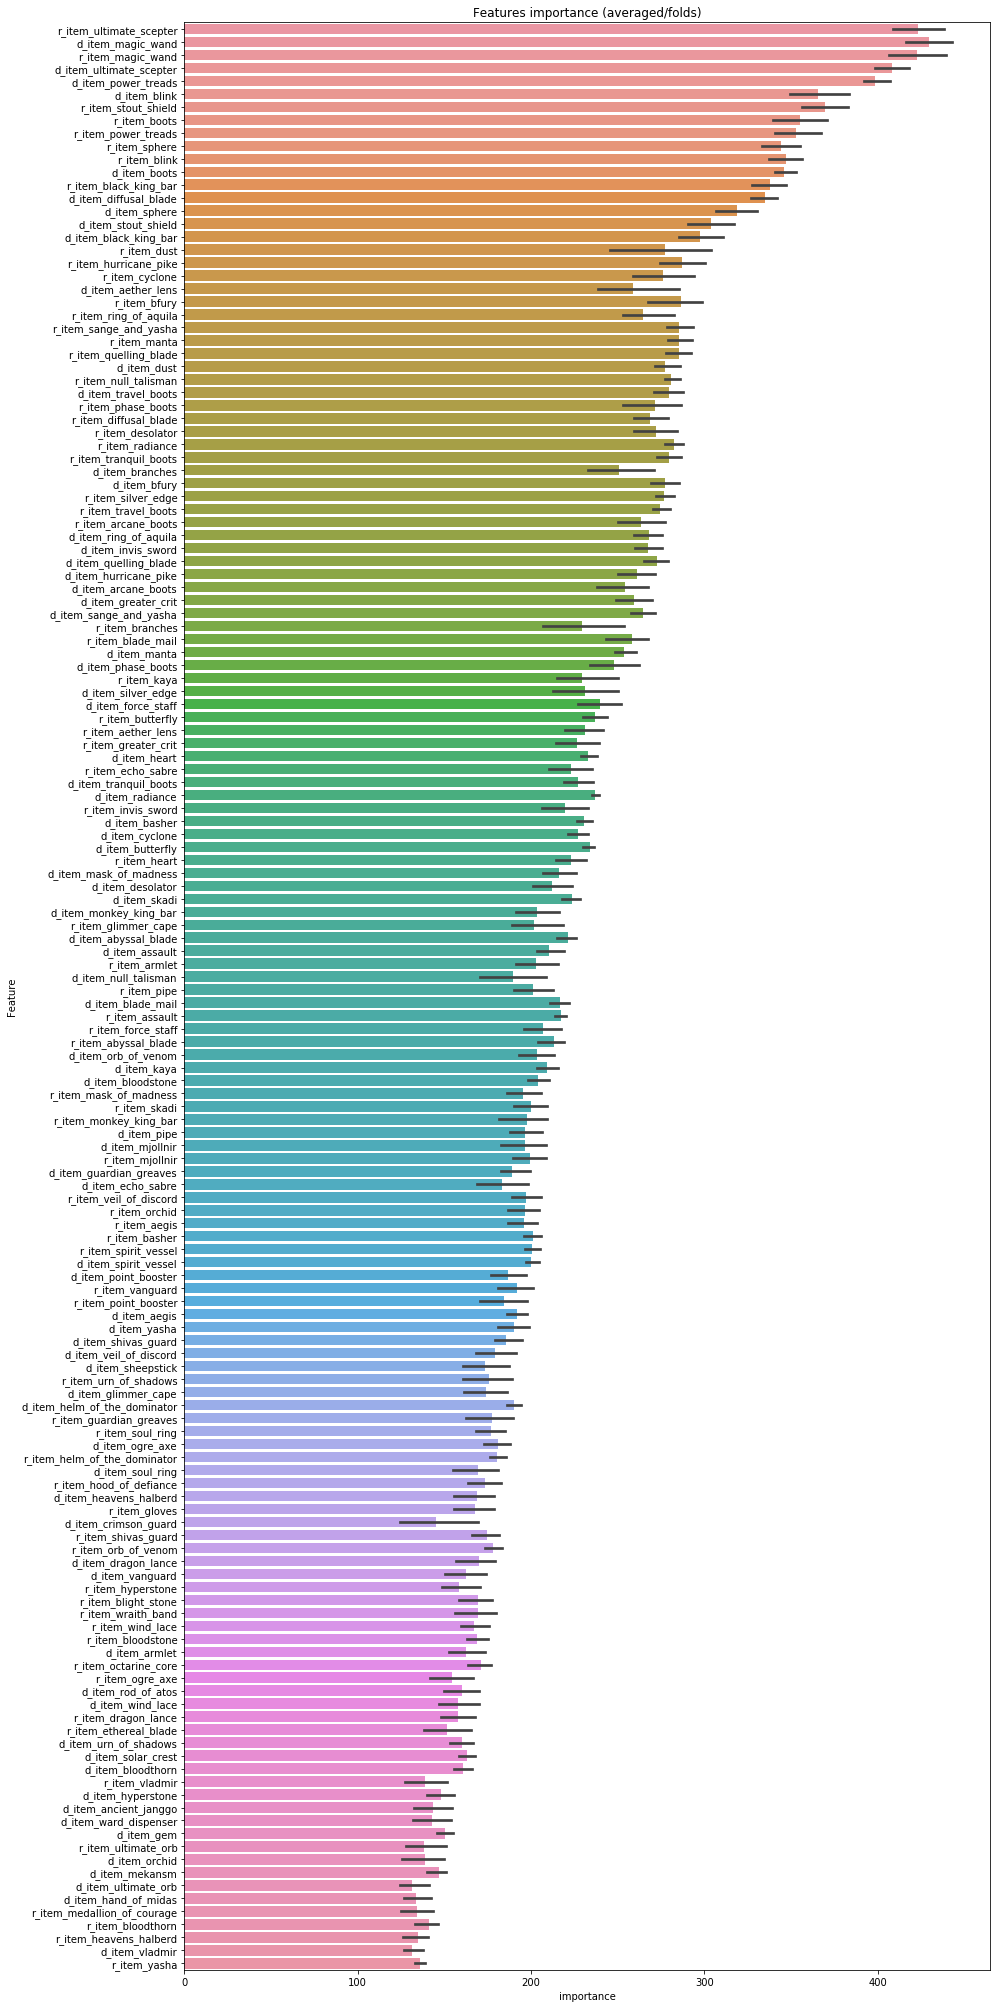

In [19]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

# Submission File

In [20]:
df_submission = pd.DataFrame({'radiant_win_prob': predictions}, 
                                 index=df_test_features.index)
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-11-07_22-40-28.csv


### You can improve this feature! There is still work to do!

### Please upvote!

![](https://pm1.narvii.com/6711/b35fe75b3f52b585f9e3efc483aa2c3cb7ea9c5c_hq.jpg)